In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_auc_score
import joblib
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv


In [3]:
train = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')
test = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')
valid = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv')

In [4]:
train.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove numbers and punctuation
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [9]:
train['text'] = train['text'].apply(clean_text)
valid['text'] = valid['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

In [14]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train = vectorizer.fit_transform(train['text'])
X_valid = vectorizer.transform(valid['text'])
X_test = vectorizer.transform(test['text'])

In [17]:
y_train = train['label'].values # this function stocks the values within a list
y_valid = valid['label'].values
y_test = test['label'].values

In [38]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

In [41]:
# Train Model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=8, batch_size=64, verbose=1)

Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9803 - loss: 0.0562 - val_accuracy: 0.8778 - val_loss: 0.4628
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9830 - loss: 0.0501 - val_accuracy: 0.8796 - val_loss: 0.4793
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9851 - loss: 0.0423 - val_accuracy: 0.8784 - val_loss: 0.5059
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9858 - loss: 0.0419 - val_accuracy: 0.8758 - val_loss: 0.5004
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9866 - loss: 0.0404 - val_accuracy: 0.8754 - val_loss: 0.4905
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9873 - loss: 0.0386 - val_accuracy: 0.8732 - val_loss: 0.5060
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9884 - loss: 0.0346 - val_accuracy: 0.8802 - val_loss: 0.5141
Epoch 8/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9889 - loss: 0.0345 - val_accuracy: 0.

In [42]:
# Evaluate Model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {acc * 100:.2f}%')

Test Accuracy: 88.30%


In [43]:
# Confusion Matrix & AUC Score
y_pred = (model.predict(X_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("AUC Score:", auc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix:
 [[2219  276]
 [ 309 2196]]
AUC Score: 0.8830127320509282


Text(0.5, 1.0, 'Confusion Matrix')

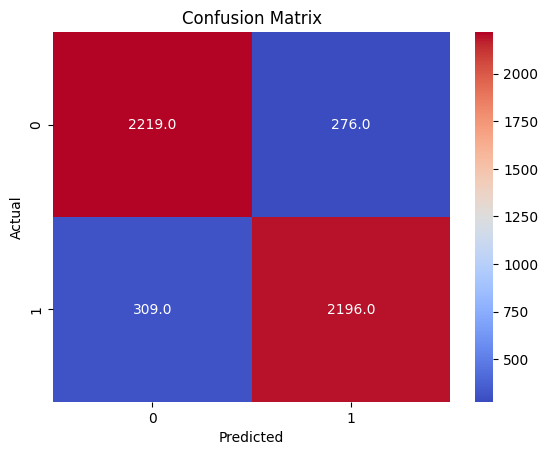

In [49]:
sns.heatmap(cm, annot=True, fmt='0.1f', cmap='coolwarm')
plt.xlabel("Predicted")  # X-axis
plt.ylabel("Actual")     # Y-axis
plt.title("Confusion Matrix")  # Title